In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from itertools import cycle

%load_ext autoreload
%autoreload 2

import helpers.helper as helpers
mpl.rc('figure', max_open_warning = 0)
%matplotlib inline

# Graded Exercise 2 

Welcome to the second graded lab. In this exercise, you will be tested on the topics of kernel methods and dimensionality reduction.

You are asked to fill in the code in a couple of cells throughout the exercise. 

Note: Each cell can be evaluated for multiple input cases and the grading will be based on the number of correct outputs.
Good luck! :-)

# Part 1: Kernel Methods

Let us consider the following dataset, where we have three classes. 

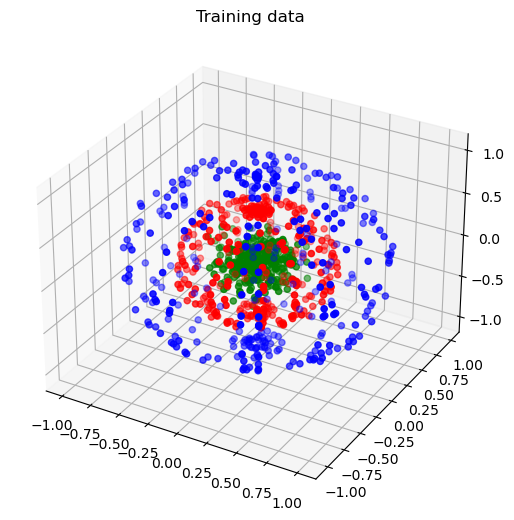

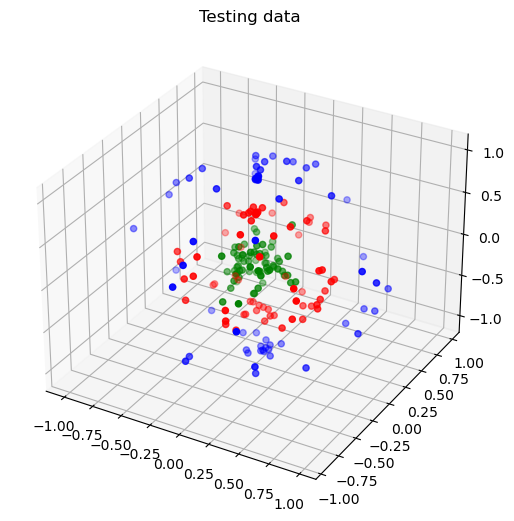

In [2]:
X, Y = helpers.generate_data_kernel()
X_train, Y_train = X[:1000, :], Y[:1000]
X_test, Y_test   = X[1000:, :], Y[1000:]

fig = helpers.vis_data_kernel(X_train, Y_train, "Training data")
fig = helpers.vis_data_kernel(X_test, Y_test, "Testing data")


We have $N$ samples in $3$ classes. Therefore we have our data $X \in \mathbb{R}^{N \times D}$ and the labels $Y \in \{-1,0,1\}^{N}$.

In [3]:
print(X_train.shape, Y_train.shape)

(1000, 3) (1000,)


As you may have noticed, it is impossible to linearly separate this data without some form of feature expansion (any 3D line you will draw will not be able to separate the three classes). Therefore, in order to classify this data accurately we will make use of kernel methods and exercise some of our knowledge of **kernel ridge regression** in the process.

First we consider the kernel.
    $$k(x_i, x_j) = 1 + x_{i}^{(1)}x_{j}^{(1)} +  x_{i}^{(2)}x_{j}^{(2)} + x_{i}^{(3)}x_{j}^{(3)} + (x_{i}^{(1)})^2 (x_{j}^{(1)})^2 + (x_{i}^{(2)})^2 (x_{j}^{(2)})^2 + (x_{i}^{(3)})^2 (x_{j}^{(3)})^2$$

Which feature expansion does this kernel come from? $x_i = \{x_i^{(1)},x_i^{(2)},x_i^{(3)}\}$,  $\sqrt(x_i) = \{\sqrt{x_i^{(1)}},\sqrt{x_i^{(2)}},\sqrt{x_i^{(3)}}\}$ , $(x_i)^2 = \{(x_i^{(1)})^2,(x_i^{(2)})^2,(x_i^{(3)})^2\}$

   A) $\phi(x_i) = [1, \sqrt(x_i), (x_i)]$
   
   B) $\phi(x_i) = [1, (x_i)]$

   C) $\phi(x_i) = [1, \sqrt(x_i), (x_i), (x_i)^2]$
    
   `correct` D) $\phi(x_i) = [1, (x_i), (x_i)^2]$
    
   E) It is impossible to find it, as it is infinite dimensional.

Let us code this kernel in the function below. 

In [76]:
def kernel_function(x_i, x_j):
    """
    Computes the kernel function between two data samples x_i and x_j
    Parameters: 
        x_i (np.array): Data sample of shape (D,)
        x_j (np.array): Data sample of shape (D,)
    Returns:
        k (float): resulting value of kernel function
    """ 
    k = 1 + x_i @ x_j + (x_i**2) @ (x_j**2)
    return k

Let us also code the functions to compute the kernel matrices K_train(X_train, X_train) and K_test(X_train, X_test).

K_train: Kernel matrix  of size (N_train x N_train) obtained by evaluating the kernel function between every pair of training samples

K_test: Kernel matrix of size (N_train x N_test) obtained by evaluating the kernel function between between each training sample and each test sample 

In [77]:
def find_kernel_matrices(X_train, X_test, kernel_function):
    """ Computes the training and testing kernel matrices using kernel_function
    
    Args:
        X_train (np.array): Training data matrix of shape (N_train, D)
        X_test (np.array): Test data matrix of shape (N_test, D)
        kernel_function (callable): Kernel function.
            
    Returns:
        k_train, k_test which correspond to:
        k_train (np.array): Kernel matrix of the shape (N_train, N_train).
        k_test (np.array): Kernel matrix of the shape (N_train, N_test).
    """
    # Compute training kernel matrix
    N_train, D = X_train.shape
    K_train = np.zeros((N_train, N_train), dtype=np.float64)
    for i in range(N_train):
        for j in range(N_train):
            K_train[i, j] = kernel_function(X_train[i], X_train[j])

    # Compute testing kernel matrix
    N_test, D = X_test.shape
    K_test = np.zeros((N_train, N_test), dtype=np.float64)
    for i in range(N_train):
        for j in range(N_test):
            K_test[i, j] = kernel_function(X_train[i], X_test[j])

    return K_train, K_test

In [78]:
K_train, K_test = find_kernel_matrices(X_train,X_test,kernel_function)

We will code a kernel **ridge** regression with a single output in order to classify this data. However, it is good to keep in mind that regression methods are not the best choice for classification tasks. 

We will be predicting the label for each data sample. Let us begin by recalling the **representer theorem** (slide 25 of Lecture 8).

"This theorem states that the minimizer of a regularized empirical risk function can be represented as a linear combination of the points in the high dimensional space."

$$ \mathbf{w}* = \mathbf{\Phi}^T \alpha^* $$

And in kernel methods, we are really optimizing for $\alpha^*$ rather than $\mathbf{w^*}$, as we do not want to deal with implementing the feature expansion $\mathbf{\Phi}$.

Let us begin by defining the regularized empirical risk parametrized by alpha, rather than the weights. 
Regularized empirical risk:
$$
    E(\alpha) = R(\alpha) + E(\mathrm{w})\\
    E(\mathrm{w}) = \mathrm{w}^T\mathrm{w} = \lambda\alpha^T\Phi\Phi^T\alpha\\
    R(\alpha) = \sum_{i=1}^N (\alpha^T\Phi\phi(x_i) - y_i)^2 
$$

In [88]:
def empirical_risk(K_train, Y_train, alpha, lambda_=1e-5):
    """     
    Calculates the regularized empirical risk parametrised by alpha, as introduced in the lectures.
    Parameters:
        K_train (np.array): Kernel matrix of the shape (N_train, N_train).
        Y_train (np.array): Training labels of shape (N_train,)
        alpha (np.array): dual weights of shape (N_train,)
        lambda (float): hyperparameter of ridge regression.
    Returns:
        R (float): regularized empirical risk value
    """ 
    R = np.sum((K_train @ alpha - Y_train)**2)
    Ew = lambda_ * (K_train @ alpha)[np.newaxis, :] @ alpha
    E = R + Ew
    return E

In [93]:
random_alpha = np.ones([X_train.shape[0],])
training_error_with_random_alpha = empirical_risk(K_train, Y_train, random_alpha, lambda_=1e-5)
print("training_error_with_random_alpha:", training_error_with_random_alpha)

training_error_with_random_alpha: [1.1821428e+09]


Now, let us find the $\alpha^*$ which minimizes the regularized empirical risk. **Note:** use `np.linalg.solve` rather than np.linalg.inv as it is more stable.

In [81]:
def find_alpha_star(K_train, Y_train, lambda_=1e-5):
    """     
    Finds the alpha_star which minimize the empirical risk
    Parameters:
        K_train (np.array) : Kernel matrix of the shape (N_train, N_train).
        Y_train (np.array) : Training labels of shape (N_train,)
        lambda  (float)    : hyperparameter of ridge regression.
    Returns:
        alpha_star (np.array): dual weights of shape (N_train,)
    """ 
    alpha_star = np.linalg.solve(K_train + lambda_ * np.eye(K_train.shape[0]), Y_train)
    assert alpha_star.shape == (K_train.shape[0],)
    return alpha_star

In [95]:
alpha_star = find_alpha_star(K_train, Y_train, lambda_=1e-5)

In [96]:
empirical_risk_with_best_alpha = empirical_risk(K_train, Y_train, alpha_star, lambda_=1e-5)
print("empirical_risk_with_best_alpha:", empirical_risk_with_best_alpha)

empirical_risk_with_best_alpha: [32.38277442]


Note that the empirical risk is much much smaller than before, now that we are using the $\alpha^*$ minimizing it. Using $\alpha^*$, we can now find the prediction on the test set using the testing kernel. Note that we never had to use the feature expanded data $\mathbf{\Phi}$ and could handle everything with the kernels!

In [97]:
def prediction(alpha_star, K_test):
    """
    Performs prediction using alpha_star on the test kernel matrix
    Parameters:
        alpha_star (np.array) : dual weights of shape (N_train,)
        K_test     (np.array) : Kernel matrix of the shape (N_train, N_test).
    Returns: 
        Y_pred (np.array): predictions of shape (N_test,)
    """ 
    Y_pred = K_test.T @ alpha_star
    return Y_pred

In [98]:
raw_pred = prediction(alpha_star, K_test)
print("prediction values of first five data samples", raw_pred[:5])

prediction values of first five data samples [ 1.02526398  1.09106355 -0.90402379 -0.20325181  1.1299383 ]


Of course, since we are trying to do classification with a regression method, we have some problems here. Our biggest problem is, how should we threshold the numbers we predicted so that we assign a label to each data sample? Luckily for you, we have found some really nice threshold values for you to use already. Code the thresholding assigment given to you as:

$$
\hat{y}_\text{thresh} = \begin{cases} 
      -1 & \hat{y} \lt -0.4 \\
      0 & -0.4\leq  \hat{y} \lt 0.3 \\
      1 & 0.3\leq \hat{y} 
   \end{cases}
$$

In [99]:
def thresholding(raw_pred):
    """
    Performs thresholding according to the piecewise function given above
    Parameters:
        raw_pred (np.array): raw predictions of shape  (N_test,), can contain values in R.
    Returns: 
        Y_pred_thresh (np.array): thresholded predictions of shape (N_test,), can only contain values {-1,0,1}
    """ 
    
    Y_pred_thresh = raw_pred.copy()
    
    Y_pred_thresh[raw_pred < -0.4] = -1
    Y_pred_thresh[np.logical_and(raw_pred >= -0.4, raw_pred < 0.3)] = 0
    Y_pred_thresh[raw_pred >= 0.3] = 1
   
    return Y_pred_thresh

In [100]:
Y_pred_dual = thresholding(raw_pred)
print("prediction values of first five data samples", Y_pred_dual[:5])

prediction values of first five data samples [ 1.  1. -1.  0.  1.]


Your accuracy is: 100.0 % 


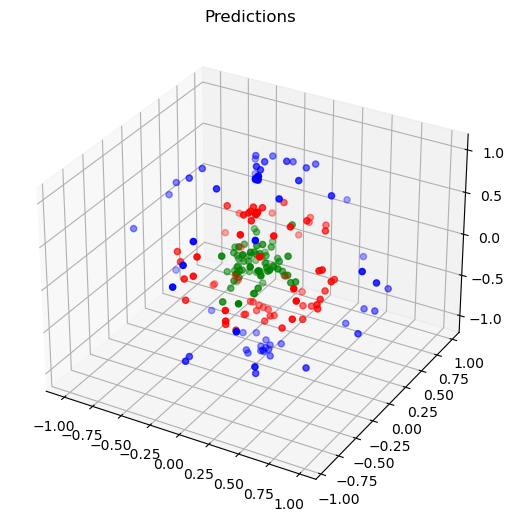

In [101]:
fig = helpers.vis_data_kernel(X_test, Y_pred_dual, "Predictions")
print("Your accuracy is:", np.mean(Y_pred_dual == Y_test)*100, "% ")

# Part 2: PCA 

Here we will build a simple PCA model on an iris dataset.

###  Dataset
Let see the PCA results on a 3-class iris dataset. First, we will load the data below.

In [102]:
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from sklearn import datasets

# load iris dataset
iris = datasets.load_iris()
data = iris['data'].astype(np.float32) 
labels = iris['target'] 
cls_names = iris['target_names']

Visualize the trends of different features together. One can see that one class is separated from the others.

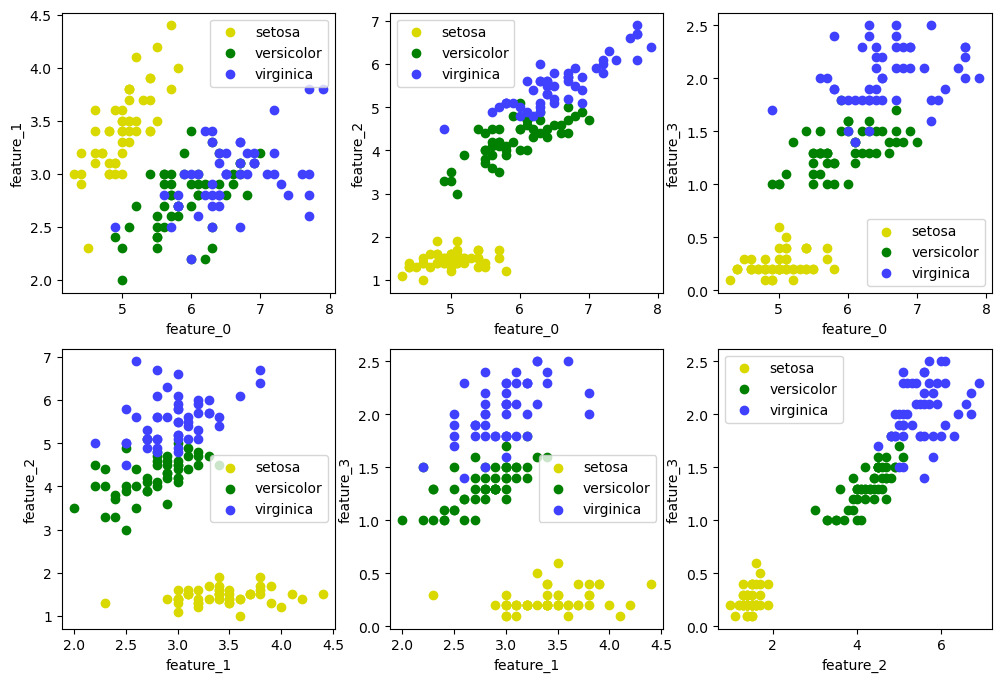

In [103]:
plt.figure(figsize=(12,8))
count = 1
colors = np.array([[0.85, 0.85, 0], [0, 0.5, 0], [0.25, 0.25, 1]])
for i in range(3):
    for j in range(i+1,4):
        plt.subplot(2,3,count)
        for ind,name in enumerate(cls_names):
            filtered_class = labels==ind
            plt.scatter(data[filtered_class,i],data[filtered_class,j],c=colors[ind,None],label=name)
        plt.xlabel(f'feature_{i}')
        plt.ylabel(f'feature_{j}')
        plt.legend()
        count +=1

### Dimensionality Reduction by PCA
In the above dataset, we have 4 features per data point. Let us now reduce the dimensionality to 2 using PCA. Implement the PCA function below.

It will take as input a dataset $\mathbf{X}\in R^{N\times D}$ and the number of principal components $d$, and return the following **in this order.**
   
* mean_data (np.array): Mean of the input data, array of shape (D,)
    
* W (np.array): Principal components, shape (D,d)
    
* eg (np.array): Variance (eigenvalues) corresponding to the principal components, ordered from the 1st to the dth, shape (d,)
    
* Y (np.array): Low-dimensional representation, i.e., data projected on the principal components, shape (N,d)
    
* exvar (float): Variance explained by the d principal components

Recall that to understand how much of variance is explained by our $d$ eigenvectors, we compute the percentage of the explained variance as
$$ 
    \begin{align}
        \mathbf{exvar} = 100 \times \frac{\sum_{i=0}^{d-1}\lambda_i}{\sum_{i=0}^{D-1}\lambda_i}
    \end{align}
$$
where $\lambda_i$ is the ith largest eigenvalue. In practice, one would often choose $d$ such that the explained variance is greater than a threshold.

In [106]:
'''
Input:
    X: NxD matrix representing our data
    d: Number of principal components to be used to reduce dimensionality
    
Output:
    mean_data: 1xD representing the mean of the input data
    W: Dxd matrix representing the principal components
    eg: d values representing the variance corresponding to the principal components, ie. the eigenvalues
    Y: Nxd data projected in the principal components' direction
    exvar: explained variance by the principal components
'''
def pca(X, d):
    
    # Compute the mean of data
    mean = np.mean(X, axis=0)
    
    # Center the data with the mean
    X_tilde = X - mean

    # Create the covariance matrix
    C = X_tilde.T @ X_tilde * 1/X.shape[0] # DxN dot NxD = DxD
    
    # Alternative covariance matrix construction
    # C = np.array([ (xi-mean).T @ (xi-mean) for xi in X_tilde])
    # C = 1/X.shape[0] * np.sum(C, axis=0)
    
    # Compute the eigenvectors and eigenvalues. Hint: use np.linalg.eigh
    eigvals, eigvecs = np.linalg.eigh(C) # symmetric matrix C
    
    # Choose the top d eigenvalues and corresponding eigenvectors. Sort the eigenvalues( with corresponding eigenvectors )
    # in decreasing order first.
    idx = np.argsort(-eigvals)[:d] # argsort elements in decreasing order
    # select d greatest eigenvalue indices

    # Create matrix W and the corresponding eigenvalues
    W = eigvecs[:, idx] # d corresponding eigenvectors
    eg = eigvals[idx] # d greatest eigenvalues

    # project the data using W
    Y = X_tilde @ W
    
    # Compute the explained variance
    exvar = np.sum(eg) / np.sum(eigvals) * 100

    return mean, W, eg, Y, exvar

Let us call the implemented function and visualize the projected data.

In [107]:
d = 2
mean, W, eg, Y, exvar = pca(data, d)
print(f'Total Variance explained by top {d} principal components is {exvar}')

Total Variance explained by top 2 principal components is 97.76852130889893


We can also visualize the classification results using the first 2 features.

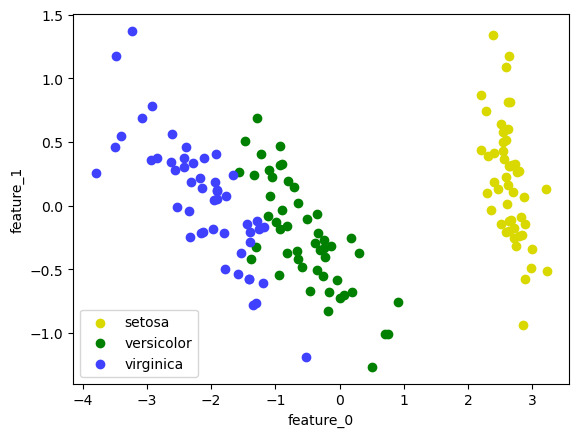

In [108]:
plt.figure()
for ind, name in enumerate(cls_names):
    filtered_class = labels==ind
    plt.scatter(Y[filtered_class,0], Y[filtered_class,1], c=colors[ind,None], label=name)

plt.xlabel(f'feature_0')
plt.ylabel(f'feature_1')
plt.legend()